# Learning sampling pattern
Second version of the full algorithm:
- Several images possible
- Learning points or cartesian mask

In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.pdhg import pdhg

#Upper level imports
import time
from UpperLevel.LBFGSB import *
from UpperLevel.cost_utils import *

### Creation of Lower level tools
Creating fourier_op, linear_op and param.

In [3]:
#Size of images to use
n = 50

x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=(n,n),implementation='cpu')

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"epsilon":1e-2,"gamma":1e-5}

### Initializing upper level
Creating images, kspace_data and updating param

In [5]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

Nimages = 3
images = [(1+0j)*im[ :, 30:206, i ]for i in range(124,124+Nimages)]

In [6]:
def reduce_img_size( n_dim, image ):
    mid = image.shape[ 0 ] // 2
    f_coef = np.fft.fftshift( np.fft.fft2( image ) )
    reduced_coef = f_coef[ mid - n_dim // 2: mid + n_dim // 2, mid - n_dim // 2: mid + n_dim // 2 ]
    reduced_image = np.fft.ifft2( np.fft.fftshift( reduced_coef ) )
    return np.abs( reduced_image )

images = [reduce_img_size(n,im) for im in images]
kspace_data = [(1+0j)*fourier_op.op(u0_mat)+0.1*np.mean(u0_mat)*np.random.randn(2*n*n).view(np.complex128) 
               for u0_mat in images]

In [7]:
param["c"] = 1e-7
param["beta"] = 3e-1

In [8]:
# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    fourier_op=fourier_op , linear_op=linear_op , param=param , 
                    verbose=-1 , my_const={"sigma":5,"tau":0.1})

# Learning points independantly

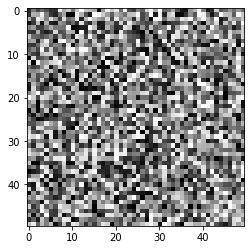

In [9]:
p0 = np.random.rand(n**2+1)
p0[-1] = 1e-2
#Choosing beta so that P(p0) = 5 ~ sum(L(û(p),u*))
param["beta"] = 5/np.sum(p0[:-1]*(1-p0[:-1]))

plt.figure()
plt.imshow(np.reshape(p0[:-1],(n,n)),cmap='gray')
plt.show()

In [10]:
pf,energy_upper,alphas = obj.optimize(p0=p0)

/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:17: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))



1 iterations: E(p)=149.0351447482026, alpha=0.009361461134161855



2 iterations: E(p)=80.61509789568225, alpha=0.006135550718201168



3 iterations: E(p)=61.17458043226069, alpha=0.0053880879913097614



4 iterations: E(p)=45.465781045693355, alpha=0.004337424109581707



5 iterations: E(p)=38.02514034850588, alpha=0.003494700638564111



6 iterations: E(p)=34.119520415150674, alpha=0.0028837919447307504



7 iterations: E(p)=32.31412061636343, alpha=0.002772761532839717



8 iterations: E(p)=31.540176065345463, alpha=0.0035962828594043165



9 iterations: E(p)=31.285941321717072, alpha=0.006722784841589807



10 iterations: E(p)=31.24450718479684, alpha=0.016663663754327884



11 iterations: E(p)=31.240249749401777, alpha=0.03138698487866566



12 iterations: E(p)=31.207888697765057, alpha=0.1625454072075782



13 iterations: E(p)=31.03966207855775, alpha=0.3827431915804169



14 iterations: E(p)=30.404293103645465, alpha=1.1361098103259115



15 iterations: E(p)=29.135210565389475,

170.74362166416736 27.85248558148684


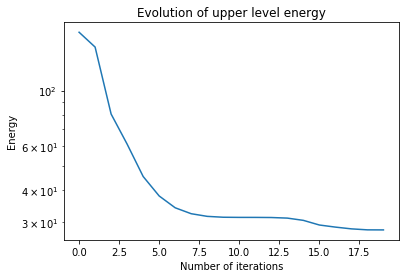

In [11]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

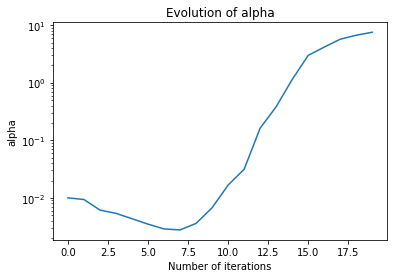

In [12]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

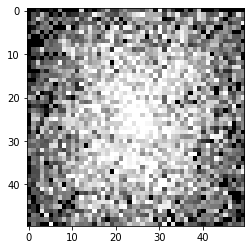

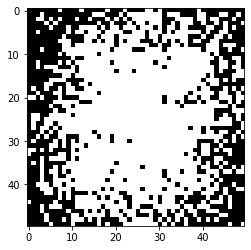

In [13]:
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

plt.figure()
plt.imshow(np.reshape(pf[:-1],(n,n)),cmap='gray')
plt.figure()
plt.imshow(np.reshape(ceiled_pf[:-1],(n,n)),cmap='gray')
plt.show()

In [14]:
print(P(pf,param["beta"]),
E(pk=pf , images=images , kspace_data=kspace_data , fourier_op=fourier_op ,
           linear_op=linear_op , param=param , verbose=-1 , const=obj.const),
np.sum(ceiled_pf))

22.418764308506315 27.85248558148684 1593


In [15]:
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.9667950852433101
Mean ssim ceiled mask:0.9574960431846574


# Learning cartesian mask

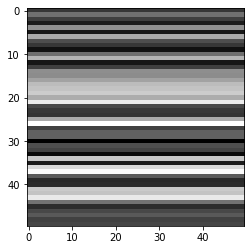

In [26]:
l0 = np.random.rand(n+1)
l0[-1] = 1e-2
#Choosing beta so that P(l0) ~ sum(L(û(p(l0)),u*))
param["beta"] = 10/np.sum(l0[:-1]*(1-l0[:-1]))

cartesian_p = pcart(l0)
cartesian_p[-1] = l0[-1]

plt.figure()
plt.imshow(np.reshape(cartesian_p[:-1],(n,n)),cmap='gray')
plt.show()

In [27]:
lf,energy_upper,alphas = obj.optimize(mask_type = "cartesian" , l0=l0)


1 iterations: E(p)=90.88498867067615, alpha=0.1922737424566355



2 iterations: E(p)=75.87420448562717, alpha=0.29233814365343375



3 iterations: E(p)=67.84336504883548, alpha=0.3741720111603184



4 iterations: E(p)=63.15683081953561, alpha=0.43770836755133646



5 iterations: E(p)=60.962061893472104, alpha=0.47505479732536365



6 iterations: E(p)=59.74495295409965, alpha=0.49032975880863144



7 iterations: E(p)=59.129466333065714, alpha=0.4902674449702093



8 iterations: E(p)=58.69512166649464, alpha=0.47788292222061146



9 iterations: E(p)=57.693198583392565, alpha=0.43858944626146457



10 iterations: E(p)=57.569458504194515, alpha=0.5083307558866028



11 iterations: E(p)=57.11756673484786, alpha=0.4913741608378003



12 iterations: E(p)=56.675847724329486, alpha=0.4538601196149587



FINISHED IN 47.405670404434204 SECONDS



122.12825817803297 56.675847724329486


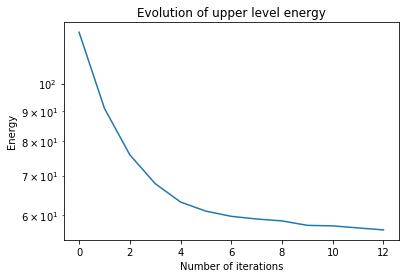

In [28]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/convergence.png")

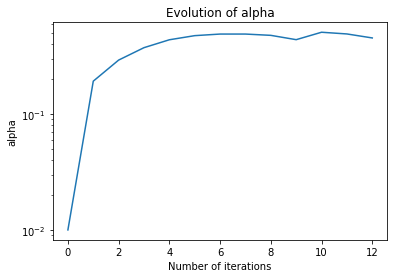

In [30]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/10 images/alpha.png")

0.4538601196149587


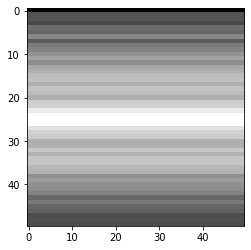

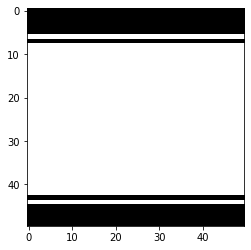

In [38]:
print(lf[-1])
pf = pcart(lf)
ceiled_pf = np.where(pf>0.5,1,0)

plt.figure()
plt.imshow(np.reshape(pf[:-1],(n,n)),cmap='gray')
plt.figure()
plt.imshow(np.reshape(ceiled_pf[:-1],(n,n)),cmap='gray')
plt.show()

In [36]:
print(P(lf,param["beta"]),
E(lk=lf , mask_type = "cartesian" , images=images , kspace_data=kspace_data , fourier_op=fourier_op ,
           linear_op=linear_op , param=param , verbose=-1 , const=obj.const),
np.sum(ceiled_pf))

48.47750267403862 56.675847724329486 1200


In [39]:
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.9523434074093244
Mean ssim ceiled mask:0.9390414636474654
